In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

In [40]:
np.random.seed(42)
#from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import autokeras as ak

from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization



In [41]:
skin_df = pd.read_csv('C:/Users/kunal_student/Desktop/Code/Github Projects/Skin Cancer Classification/data/HAM10000/HAM10000_metadata.csv')


SIZE=32

In [42]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extr

C:\Users\kunal_student\AppData\Local\Temp\ipykernel_9320\3797679965.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


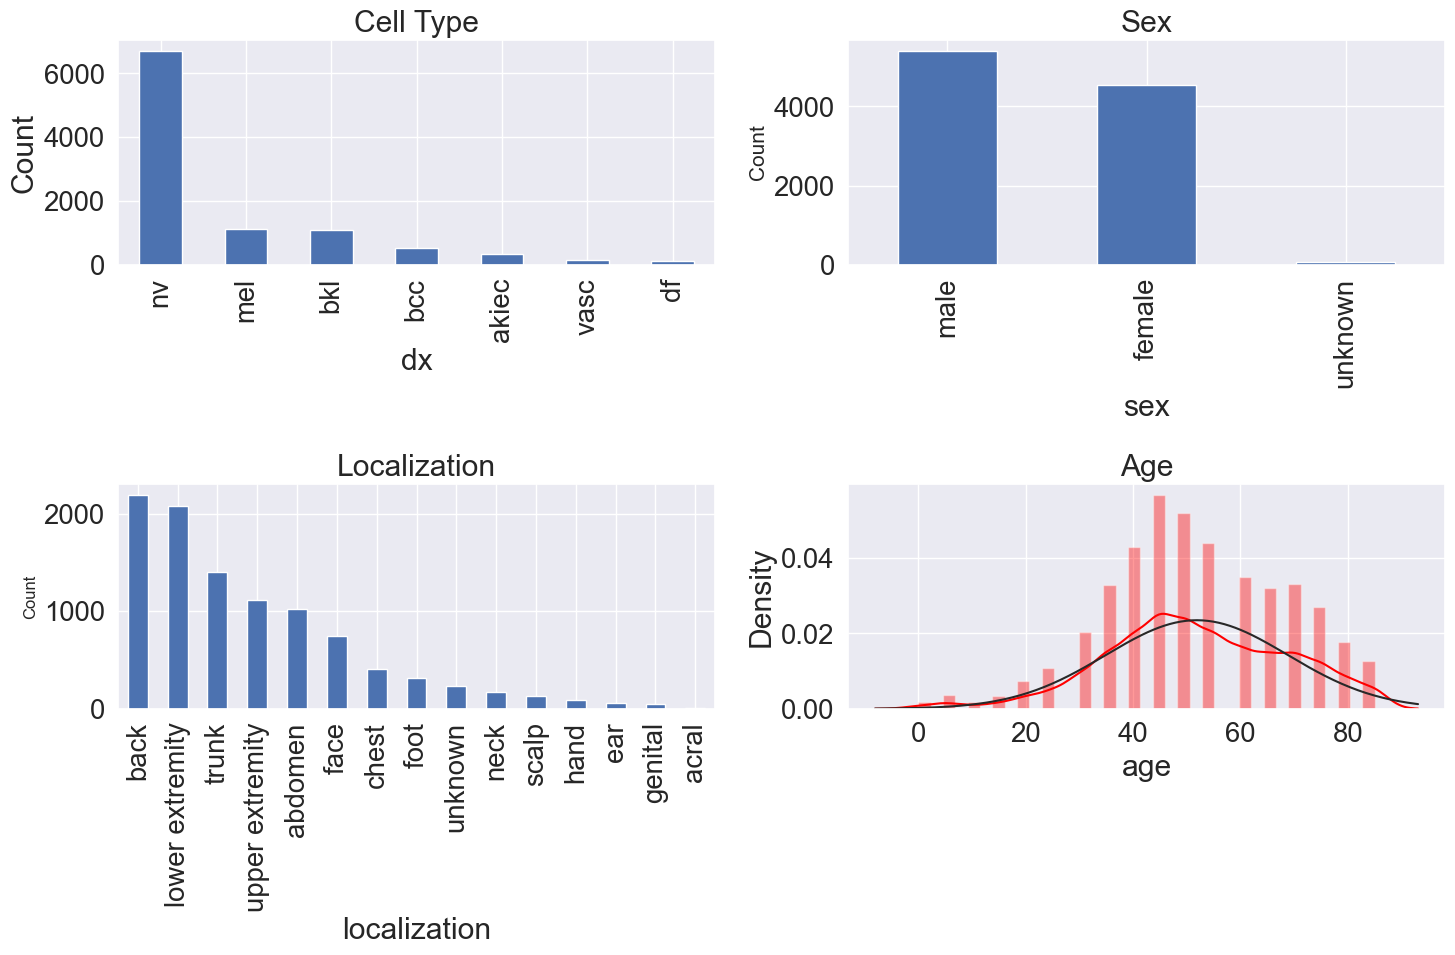

In [43]:

# Data distribution visualization
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()



In [44]:

# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
print(skin_df_balanced['label'].value_counts())


label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64
label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64


In [45]:

image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('C:/Users/kunal_student/Desktop/Code/Github Projects/Skin Cancer Classification/data/HAM10000/', '*', '*.jpg'))}
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))


n_samples = 5  


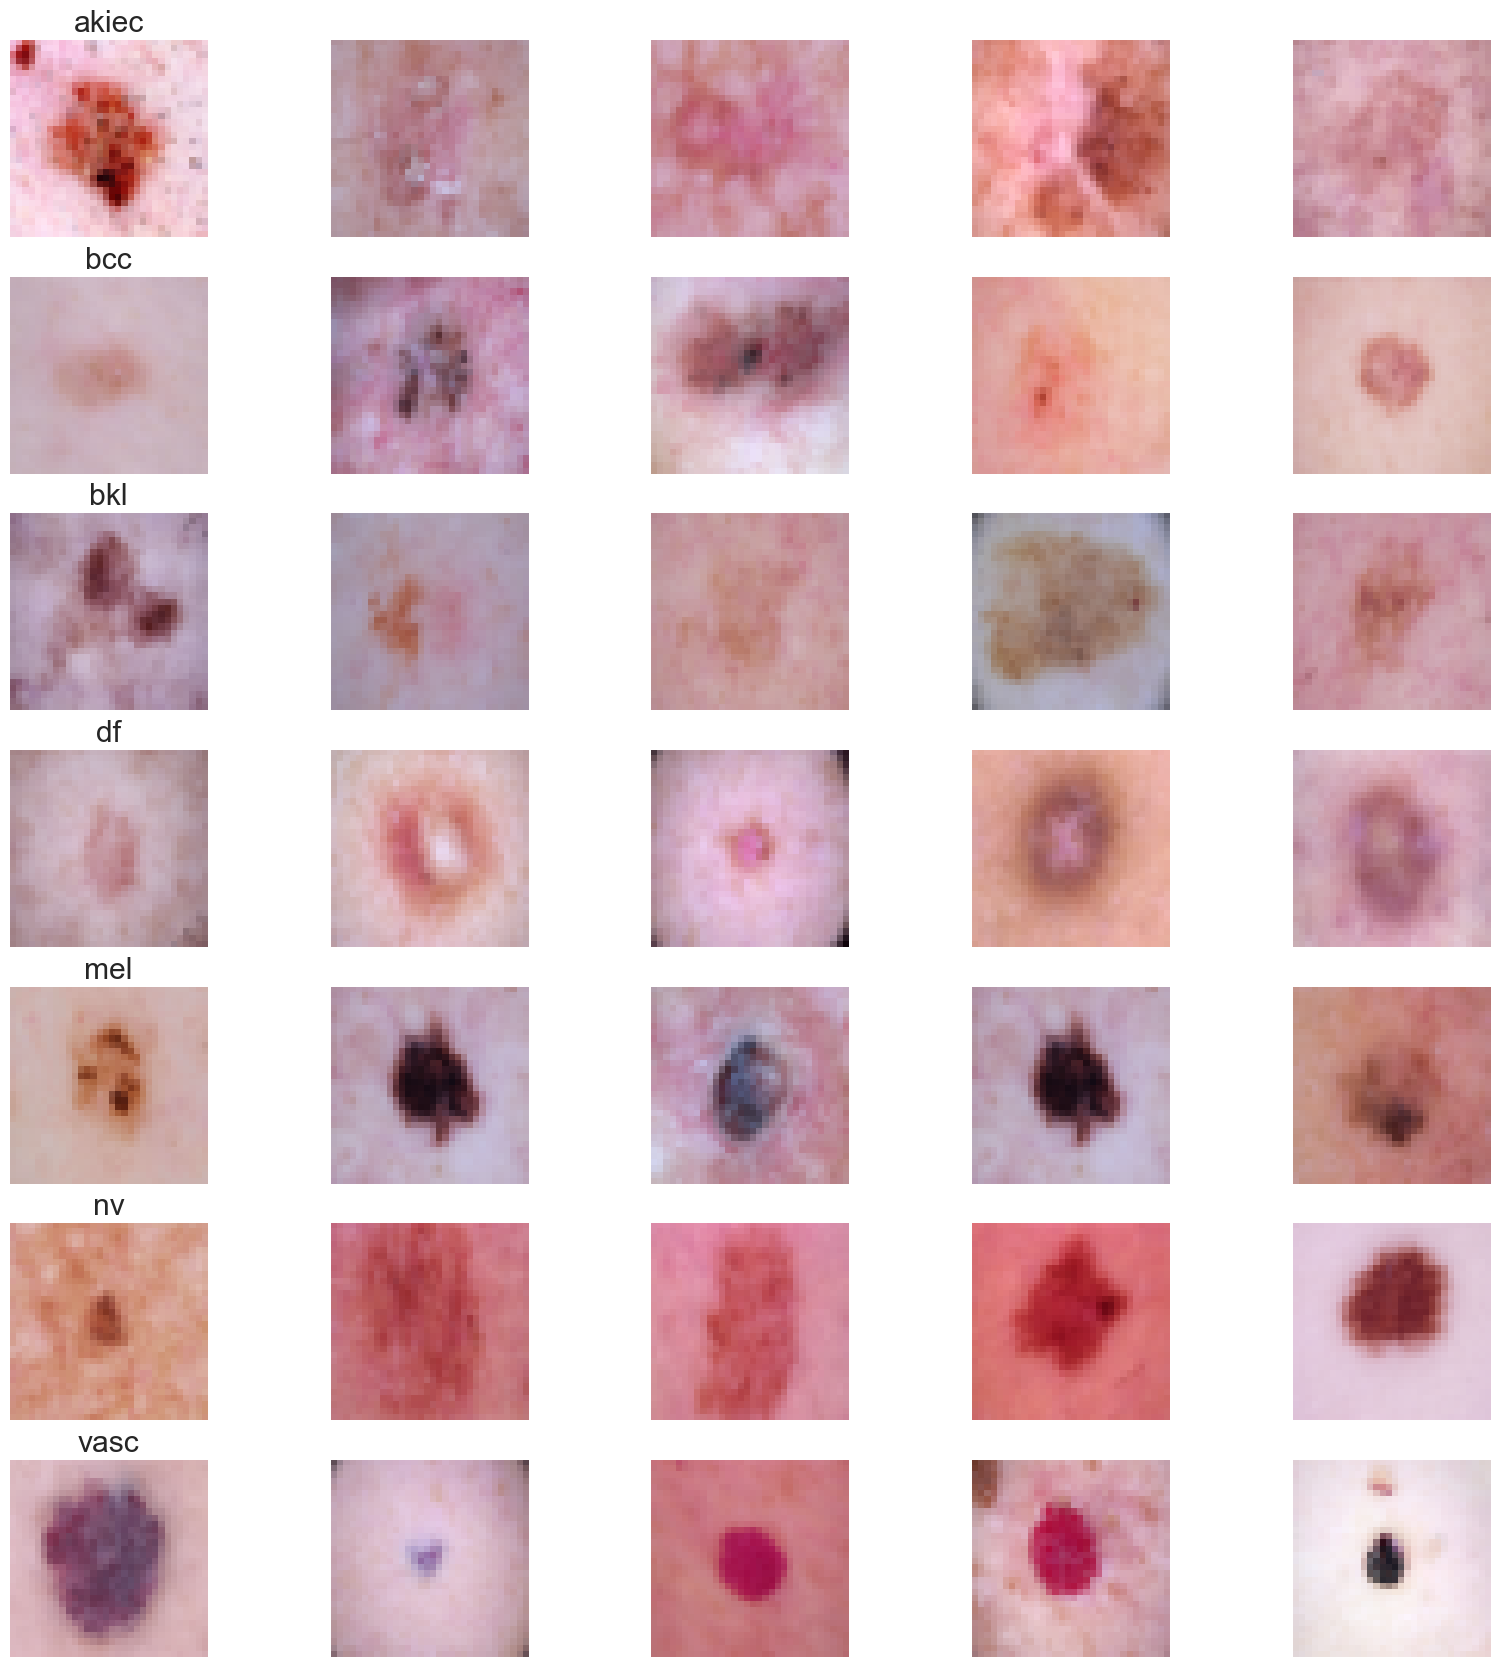

In [46]:

# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')


In [47]:

# #Convert dataframe column of images into numpy array
# X = np.asarray(skin_df_balanced['image'].tolist())
# X = X/255. # Scale values to 0-1. You can also used standardscaler or other scaling methods.
# Y=skin_df_balanced['label'] #Assign label values to Y
# Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
# #Split to training and testing. Get a very small dataset for training as we will be 
# # fitting it to many potential models. 
# x_train, x_train, x_train, x_train = train_test_split(X, Y_cat, test_size=0.95, random_state=42)

# #Further split data into smaller size to get a small test dataset. 
# x_unused, x_valid, y_unused, y_valid = train_test_split(x_train, x_train, test_size=0.05, random_state=42)

# #Define classifier for autokeras. Here we check 25 different models, each model 25 epochs
# clf = ak.ImageClassifier(max_trials=25) #MaxTrials - max. number of keras models to try
# clf.fit(x_train, x_train, epochs=25)



In [49]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)



In [51]:
num_classes = 7
model = tf.keras.Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])




Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 15, 15, 256)       0         
 ng2D)                                                           
                                                                 
 dropout_11 (Dropout)        (None, 15, 15, 256)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 6, 6, 128)         0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 6, 6, 128)        

In [55]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 16 
epochs = 80

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/80
165/165 - 13s - loss: 1.5599 - acc: 0.3459 - val_loss: 1.4851 - val_acc: 0.3669 - 13s/epoch - 79ms/step
Epoch 2/80
165/165 - 12s - loss: 1.4939 - acc: 0.3817 - val_loss: 1.4893 - val_acc: 0.3897 - 12s/epoch - 75ms/step
Epoch 3/80
165/165 - 12s - loss: 1.4213 - acc: 0.4286 - val_loss: 1.4415 - val_acc: 0.4343 - 12s/epoch - 74ms/step
Epoch 4/80
165/165 - 12s - loss: 1.4020 - acc: 0.4408 - val_loss: 1.3599 - val_acc: 0.4331 - 12s/epoch - 73ms/step
Epoch 5/80
165/165 - 12s - loss: 1.3613 - acc: 0.4488 - val_loss: 1.3742 - val_acc: 0.4091 - 12s/epoch - 73ms/step
Epoch 6/80
165/165 - 12s - loss: 1.3631 - acc: 0.4598 - val_loss: 1.3062 - val_acc: 0.4846 - 12s/epoch - 74ms/step
Epoch 7/80
165/165 - 12s - loss: 1.3455 - acc: 0.4644 - val_loss: 1.4486 - val_acc: 0.3760 - 12s/epoch - 73ms/step
Epoch 8/80
165/165 - 12s - loss: 1.3190 - acc: 0.4770 - val_loss: 1.2942 - val_acc: 0.4857 - 12s/epoch - 73ms/step
Epoch 9/80
165/165 - 12s - loss: 1.2653 - acc: 0.4975 - val_loss: 1.3075 - val_a

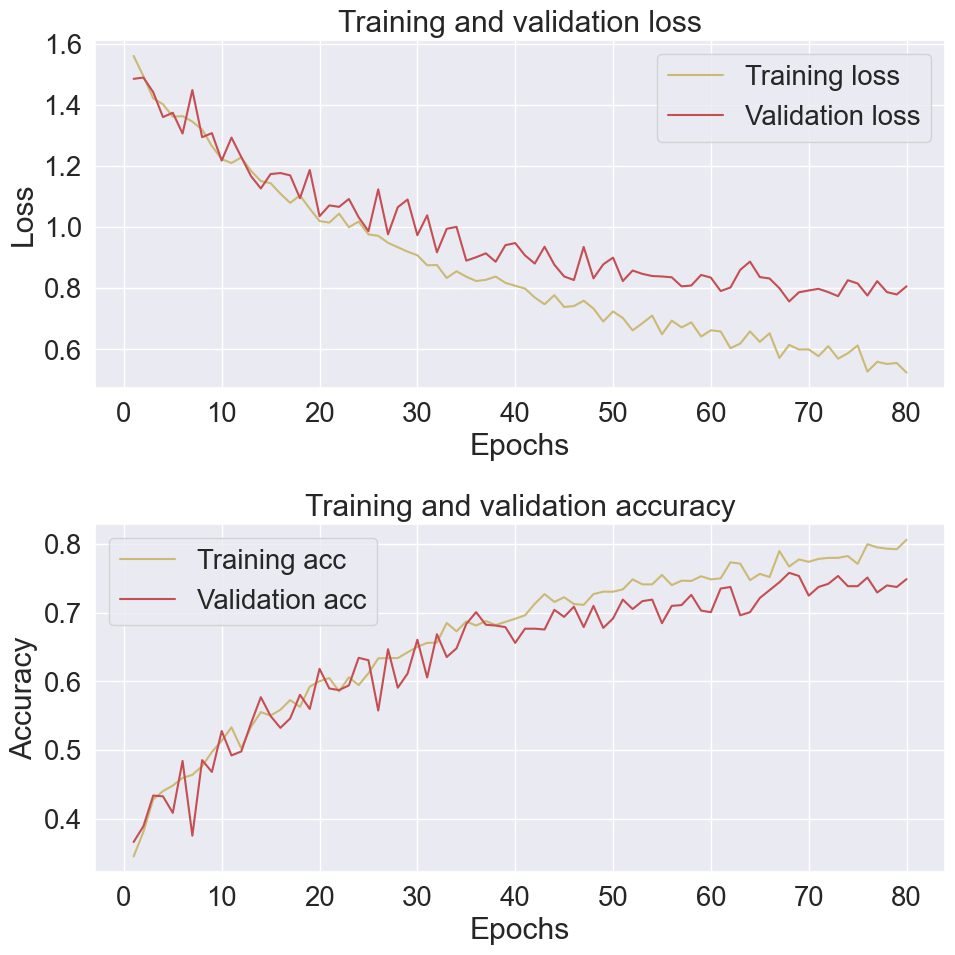

In [70]:
#plot the training and validation accuracy and loss at each epoch
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, 'y', label='Training loss')
ax1.plot(epochs, val_loss, 'r', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()



acc = history.history['acc']
val_acc = history.history['val_acc']
ax2.plot(epochs, acc, 'y', label='Training acc')
ax2.plot(epochs, val_acc, 'r', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()
plt.show()


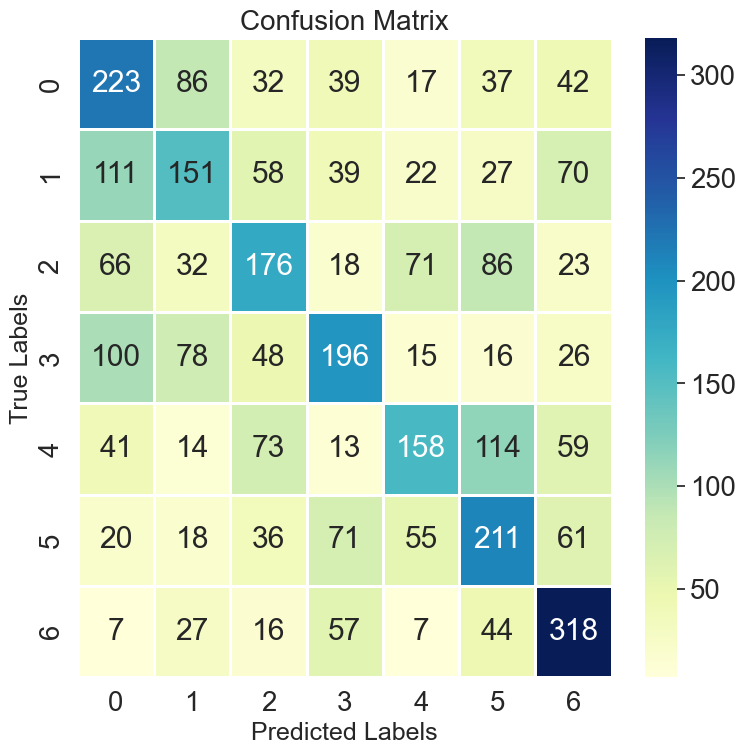

In [71]:
# #Print confusion matrix
# Assuming cm, y_true, and y_pred_classes are already defined
fig, ax = plt.subplots(figsize=(8, 8))
sns.set(font_scale=1.8)
sns.heatmap(cm, annot=True, fmt='d', linewidths=1, ax=ax, cmap="YlGnBu")
plt.xlabel('Predicted Labels', fontsize=18)
plt.ylabel('True Labels', fontsize=18)
plt.title('Confusion Matrix', fontsize=20)
plt.tight_layout()
plt.show()



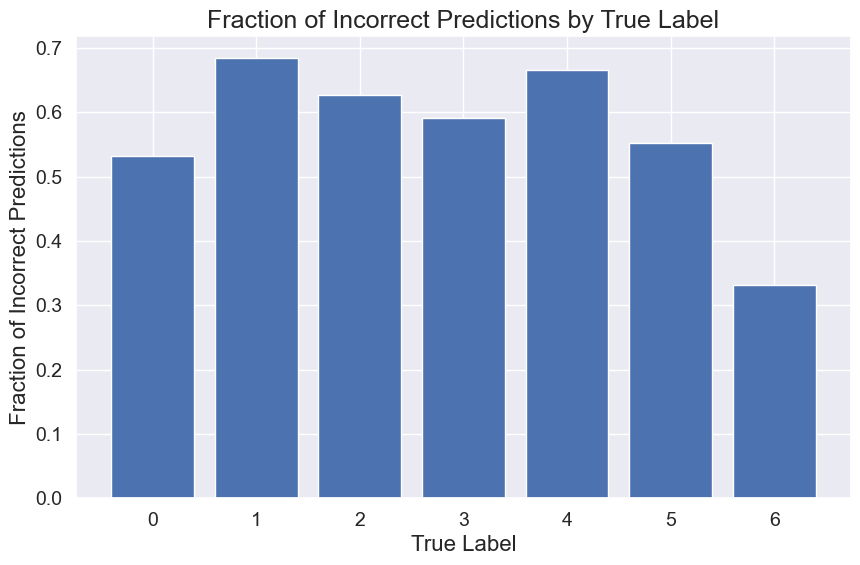

In [72]:

# Plot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)

# Create a larger figure
plt.figure(figsize=(10, 6))

# Increase the font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Create a bar chart with labels and titles
plt.bar(np.arange(7), incorr_fraction, tick_label=np.arange(7))
plt.xlabel('True Label', fontsize=16)
plt.ylabel('Fraction of Incorrect Predictions', fontsize=16)
plt.title('Fraction of Incorrect Predictions by True Label', fontsize=18)

# Show the plot
plt.show()